# 4. Pastas Project

In this notebook you will learn:
- what a pastas project is.
- how observations series, stresses and models are stored in a pastas project.
- how to do bulk operations on pastas models.
- how to write and read a pastas project from a file.


In order to do bulk operations on time series models you can use a Pastas Project. A Project is a Python class that contains observations, stresses and models of multiple locations. This class has convenient methods to store time series data, create models, add stressmodels and summarize the results. This notebook is an example of the current possibilities.

In [1]:
# First perform the necessary imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
%matplotlib inline

In [2]:
## Starting a new Project
pr = ps.Project(name='project for notebook')

## Add observations
We can add oseries to the project. Set kind to 'oseries' to add the series as observations. Observation-series are added to pr.oseries, which is a Pandas DataFrame. The measurement-TimeSeries is in the 'series'-column. Metadata provided to add_series is shown in the other columns of pr.oseries.

In [3]:
# add the observations in all the files in the data-directory that end with _1.csv
datapath = r'data\nb4'
files = [x for x in os.listdir(datapath) if x.endswith('_1.csv')]
for file in files:
    fname = os.path.join(datapath,file)
    series = ps.read_dino(fname)
    pr.add_series(series, kind='oseries')
    
# show the contents of pr.oseries
pr.oseries

INFO: Cannot determine frequency of series B32D0136_1
INFO: Time Series B32D0136_1: 2 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of series B33A0113_1
INFO: Cannot determine frequency of series B58C0698_1
INFO: Time Series B58C0698_1: 6 nan-value(s) was/were found and filled with: drop


,name,series,kind,x,y,z,projection,Locatie,Filternummer,Externe aanduiding,X-coordinaat,Y-coordinaat,Maaiveld (cm t.o.v. NAP),Datum maaiveld gemeten,Startdatum,Einddatum,Meetpunt (cm t.o.v. NAP),Meetpunt (cm t.o.v. MV),Bovenkant filter (cm t.o.v. NAP),Onderkant filter (cm t.o.v. NAP)
B32D0136_1,B32D0136_1,"TimeSeries(name=B32D0136_1, freq=None, tmin=19...",oseries,153344,457123,0.24,epsg:28992,B32D0136,001,32DP0136,153344,457123,1095,22-06-1988,22-06-1988,05-11-2010,1125,30,124,-76
B33A0113_1,B33A0113_1,"TimeSeries(name=B33A0113_1, freq=None, tmin=19...",oseries,189780,471810,-5.6,epsg:28992,B33A0113,001,33AP0113,189780,471810,7837,05-10-1988,05-10-1988,25-05-2009,7907,70,-460,-660
B58C0698_1,B58C0698_1,"TimeSeries(name=B58C0698_1, freq=None, tmin=19...",oseries,181600,359260,26.22,epsg:28992,B58C0698,1,58CP7805,181600,359260,3017,28-10-85,23-08-02,28-06-15,3025,8,2647,2597


#### Exercise 1 <a name="ex1"></a>
Create a pastas project. Add the observations in the `data\nb4\ex1`  to the model. Which measurements series has the lowest filter?

<a href="#ans1">Answer Exercise 1</a>

## Stresses
And we can add stresses. To make pr.add_recharge work later, we have to add the precipitation-series as kind='prec' and the evaporation-series as kind='evap'. Stress-series are added to pr.stresses, which is a Pandas DataFrame (just like pr.oseries). The stress-TimeSeries is in the 'series'-column. Metadata provided to add_series is shown in the other columns of pr.stresses.

In [4]:
# add evaporation
fname = os.path.join(datapath,'KNMI_Bilt.txt')
series = ps.read_knmi(fname, variables='EV24')
pr.add_series(series, kind='evap', settings='evap')

# add precipitation
fname = os.path.join(datapath,'KNMI_Akkrum.txt')
series = ps.read_knmi(fname, variables='RD')
pr.add_series(series, kind='prec', settings='prec')


# show the contents of pr.stresses
pr.stresses

INFO: Inferred frequency from time series EV24 DE BILT: freq=D 
INFO: Inferred frequency from time series RD 89: freq=D 


,name,series,kind,x,y,z,projection,description
EV24 DE BILT,EV24 DE BILT,"TimeSeries(name=EV24 DE BILT, freq=None, tmin=...",evap,5.18,52.1,1.9,epsg:4326,Referentiegewasverdamping (Makkink) (in m);
RD 89,RD 89,"TimeSeries(name=RD 89, freq=None, tmin=1995-10...",prec,0,0,0,None,24-uur som van de neerslag in m van 08.00 voor...


#### Exercise 2 <a name="ex2"></a>
Add the evaporation from De Bilt and the precipitation from Akkrum to the project you made in Exercise 1.

<a href="#ans2">Answer Exercise 2</a>

## Make models
We can make models and add recharge. Models are added to pr.models, which is a dictionary with the model-names as the keys, and the models as the values. The add_recharge method finds the closest precipitation- and evaporation-series to the measurement location that the model describes.

The file that we used for precipitation did not contain any coordinates, which will therefore default to 0.0. The evaporation-file contains coordinates in epsg:4326, while our observation-files contain coordinates in epsg:28992. Right now we do not transform coordinates. So finding the closest precipitation- and evaporation-series will normally give wrong results. As we have only one precipitation and evaporation series however, this is not a problem.

In the code-section below, we make three models with recharge and solve them.

In [5]:
for name in pr.oseries.index:
    ml = pr.add_model(name)
    pr.add_recharge(ml)
    ml.solve(report=False)
    
# show the contents of pr.models
pr.models

{'B32D0136_1': Model(oseries=B32D0136_1, name=B32D0136_1, constant=True, noisemodel=True),
 'B33A0113_1': Model(oseries=B33A0113_1, name=B33A0113_1, constant=True, noisemodel=True),
 'B58C0698_1': Model(oseries=B58C0698_1, name=B58C0698_1, constant=True, noisemodel=True)}

#### Exercise 3 <a name="ex3"></a>
Create models of your pastas project from exercise 2 and solve them.

<a href="#ans3">Answer Exercise 3</a>

## Plot individual results
Take one of the models and plot the decomposition. As we can see, the precipitation series does not contain the first few years of the simulation. The start- and end-dates of the model (tmin and tmax) are solely determined by the observation-series.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000177B2DF3E48>,
      dtype=object)

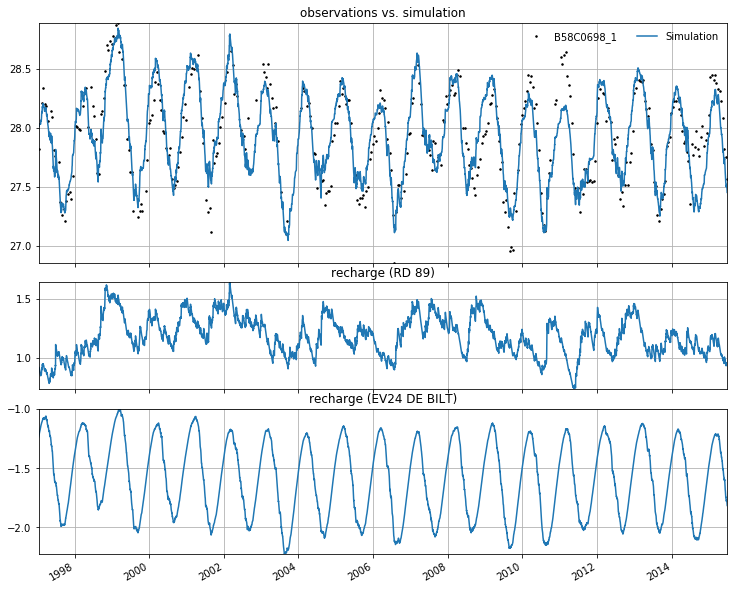

In [6]:
name = 'B58C0698_1'
ml = pr.models[name]
ml.plots.decomposition()

## Get some statistics / parameters of all models
Make a table with some statistics of the models

In [7]:
pr.get_statistics(['evp','aic'])

,evp,aic
B32D0136_1,29.568438,11.858385
B33A0113_1,30.064439,13.077533
B58C0698_1,77.715609,8.840875


Make a table with some parameters of the models

In [8]:
pr.get_parameters(['recharge_A','constant_d','noise_alpha'])

,recharge_A,constant_d,noise_alpha
B32D0136_1,2153.250241,3.049998,1573.638810
B33A0113_1,2083.711963,27.930984,4982.266792
B58C0698_1,504.510852,28.333742,75.916491


Get the EVP from the models. What do you think?

#### Exercise 4 <a name="ex4"></a>
Get the EVP from the models in your pastas project from exercise 3. What do you think?

<a href="#ans4">Answer Exercise 4</a>

#### Exercise 5 <a name="ex5"></a>

Improve the models in your project from exercise 4 by replacing the precipitation from Akkrum with measurements from IJsselstein use this website https://www.knmi.nl/nederland-nu/klimatologie/monv/reeksen. And replace the evaporation from De Bilt with the evaporation from Arcen using this website https://www.knmi.nl/nederland-nu/klimatologie/daggegevens. Does this improve the EVP? Plot the results of model B52D0502_1, what do you see?

<a href="#ans5">Answer Exercise 5</a>

#### Exercise 6 <a name="ex6"></a>
There are no evaporation measurements at Arcen before 1991. Change the calibration period of the models using tmin in such a way that a more realistic model is created.

<a href="#ans6">Answer Exercise 6</a>

#### Exercise 7 <a name="ex7"></a>
Add a step trend to the models in january 2010. Solve the models and explore the results. What happens?

<a href="#ans7">Answer Exercise 7</a>

## Make a map
We can make a map of the locations of oseries. The mapping-functionality of a Pastas Project need to be expanded.

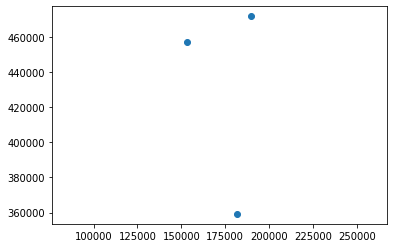

In [9]:
f,ax= plt.subplots()
ax.axis('equal')
pr.maps.series(kind='oseries')

## Saving and loading a project
We can save an entire project, with all its series and models, to a file.

In [10]:
pr.to_file('pastas_project.pas')

pastas_project.pas file successfully exported


Later we can reload this project again

In [11]:
pr = ps.io.load('pastas_project.pas')

INFO: Cannot determine frequency of series B32D0136_1
INFO: Time Series B32D0136_1: 2 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of series B33A0113_1
INFO: Cannot determine frequency of series B58C0698_1
INFO: Time Series B58C0698_1: 6 nan-value(s) was/were found and filled with: drop
INFO: Pastas Project from file pastas_project.pas successfully loaded. This file was created with was Pastas0.13.0. Your current version of Pastas is: 0.13.0


Test if everything went ok by plotting the decomposition of B58C0698_1 again. This figure is exactly the same as before.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000177B316FD30>,
      dtype=object)

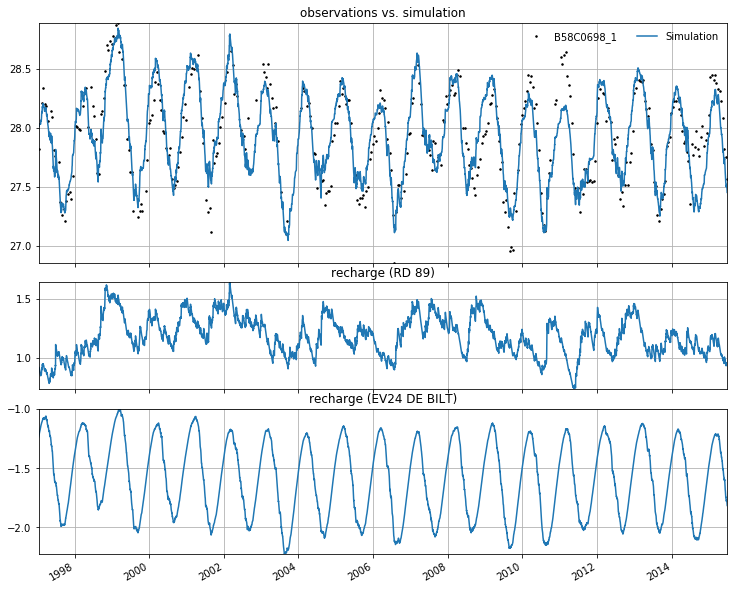

In [12]:
name = 'B58C0698_1'
ml = pr.models[name]
ml.plots.decomposition()


## Answers

#### <a href="#ex1">Answer exercise 1</a> <a name="ans1"></a>

Measurement point B52D0192_2 has the lowest filter. This can be seen in the column `Onderkant filter (cm t.o.v. NAP)` from the dataframe: `pr_q.oseries`. This is a hard question if you don't know Dutch (sorry!).

In [13]:
# Starting a new Project
pr_q = ps.Project(name='exercise1')

# add the observations in all the files in the data-directory that end with _1.csv
datapath_ex1 = r'data\nb4\ex1'
files = [x for x in os.listdir(datapath_ex1) if x.endswith('_1.csv')]
for file in files:
    fname = os.path.join(datapath_ex1,file)
    series = ps.read_dino(fname)
    pr_q.add_series(series, kind='oseries')
# show the contents of pr.oseries
meetreeks = pr_q.oseries.loc['B52C2089_1','series'].series
pr_q.oseries

INFO: Cannot determine frequency of series B52C2089_1
INFO: Time Series B52C2089_1: 121 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of series B52D0192_1
INFO: Time Series B52D0192_1: 30 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of series B52D0192_2
INFO: Time Series B52D0192_2: 24 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of series B52D0201_1
INFO: Time Series B52D0201_1: 187 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of series B52D0201_2
INFO: Time Series B52D0201_2: 17 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of series B52D0495_1
INFO: Time Series B52D0495_1: 10 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of series B52D0495_2
INFO: Time Series B52D0495_2: 9 nan-value(s) was/were found and filled with: drop
INFO: Cannot determine frequency of seri

,name,series,kind,x,y,z,projection,Locatie,Filternummer,Externe aanduiding,X-coordinaat,Y-coordinaat,Maaiveld (cm t.o.v. NAP),Datum maaiveld gemeten,Startdatum,Einddatum,Meetpunt (cm t.o.v. NAP),Meetpunt (cm t.o.v. MV),Bovenkant filter (cm t.o.v. NAP),Onderkant filter (cm t.o.v. NAP)
B52C2089_1,B52C2089_1,"TimeSeries(name=B52C2089_1, freq=None, tmin=19...",oseries,188619,383753,29.4,epsg:28992,B52C2089,001,,188619,383753,3033,23-03-2016,23-03-2016,19-12-2018,3084,51,2990,2890
B52D0192_1,B52D0192_1,"TimeSeries(name=B52D0192_1, freq=None, tmin=19...",oseries,190715,383280,30.28,epsg:28992,B52D0192,001,52DP7064,190715,383280,3123,02-05-1980,02-05-1980,30-05-2017,3133,10,3053,3003
B52D0192_2,B52D0192_2,"TimeSeries(name=B52D0192_2, freq=None, tmin=19...",oseries,190715,383280,28.115,epsg:28992,B52D0192,002,52DP7064,190715,383280,3123,02-05-1980,02-05-1980,30-05-2017,3144,21,2819,2804
B52D0201_1,B52D0201_1,"TimeSeries(name=B52D0201_1, freq=None, tmin=19...",oseries,193221,378361,31.54,epsg:28992,B52D0201,001,52DP9012,193221,378361,3301,12-05-2016,12-05-2016,05-04-2018,3344,43,3204,3104
B52D0201_2,B52D0201_2,"TimeSeries(name=B52D0201_2, freq=None, tmin=19...",oseries,193221,378361,29.54,epsg:28992,B52D0201,002,52DP9012,193221,378361,3301,12-05-2016,12-05-2016,05-04-2018,3340,39,3004,2904
B52D0495_1,B52D0495_1,"TimeSeries(name=B52D0495_1, freq=None, tmin=20...",oseries,192798,378240,31.4,epsg:28992,B52D0495,001,52DP0495,192798,378240,3215,18-06-2001,18-06-2001,05-04-2018,3247,32,3145,3135
B52D0495_2,B52D0495_2,"TimeSeries(name=B52D0495_2, freq=None, tmin=20...",oseries,192798,378240,29.1,epsg:28992,B52D0495,002,52DP0495,192798,378240,3215,18-06-2001,18-06-2001,05-04-2018,3249,34,2915,2905
B52D0502_1,B52D0502_1,"TimeSeries(name=B52D0502_1, freq=None, tmin=19...",oseries,192320,382590,30.075,epsg:28992,B52D0502,001,52DP7049,192320,382590,3129,22-03-1993,22-03-1993,27-05-2017,3154,25,3021,2994


#### <a href="#ex2">Answer exercise 2</a> <a name="ans2"></a>

In [14]:
# add evaporation
fname = os.path.join(datapath,'KNMI_Bilt.txt')
series = ps.read_knmi(fname, variables='EV24')
pr_q.add_series(series, kind='evap', settings='evap')

# add precipitation
fname = os.path.join(datapath,'KNMI_Akkrum.txt')
series = ps.read_knmi(fname, variables='RD')
pr_q.add_series(series, kind='prec', settings='prec')


# show the contents of pr.stresses
pr_q.stresses

INFO: Inferred frequency from time series EV24 DE BILT: freq=D 
INFO: Inferred frequency from time series RD 89: freq=D 


,name,series,kind,x,y,z,projection,description
EV24 DE BILT,EV24 DE BILT,"TimeSeries(name=EV24 DE BILT, freq=None, tmin=...",evap,5.18,52.1,1.9,epsg:4326,Referentiegewasverdamping (Makkink) (in m);
RD 89,RD 89,"TimeSeries(name=RD 89, freq=None, tmin=1995-10...",prec,0,0,0,None,24-uur som van de neerslag in m van 08.00 voor...


#### <a href="#ex3">Answer exercise 3</a> <a name="ans3"></a>

In [15]:
#Exercise 3
pr_q.add_models()
pr_q.add_recharge()
pr_q.solve_models()

In [16]:
# alternative with a for-loop
for name in pr_q.oseries.index:
    ml = pr_q.add_model(name)
    pr_q.add_recharge(ml)
    ml.solve(report=False)

#### <a href="#ex4">Answer exercise 4</a> <a name="ans4"></a>

See the explained variance (evp) in the cell below. The evp is rather low. In general people use an evp value of more than 70-80% for a reasonable fit.

In [17]:
pr_q.get_statistics(['evp'])

B52C2089_1    15.701275
B52D0192_1    34.915125
B52D0192_2    64.315848
B52D0201_1    22.205044
B52D0201_2    22.678301
B52D0495_1    15.659999
B52D0495_2     3.298848
B52D0502_1    52.680140
Name: evp, dtype: float64

#### <a href="#ex5">Answer exercise 5</a> <a name="ans5"></a>

The evaporation time series of Arcen has no values before 1991 and therefore the model of B52D0502_1 and others have a poor fit/low evp. 

INFO: Inferred frequency from time series EV24 391: freq=D 
INFO: Inferred frequency from time series RD 913: freq=D 
INFO: Stress with name EV24 DE BILT deleted from the database.
INFO: Stress with name RD 89 deleted from the database.


B52C2089_1    59.358382
B52D0192_1    42.102549
B52D0192_2    70.530140
B52D0201_1    73.762643
B52D0201_2    84.374921
B52D0495_1    41.329586
B52D0495_2    39.014037
B52D0502_1    65.990052
Name: evp, dtype: float64


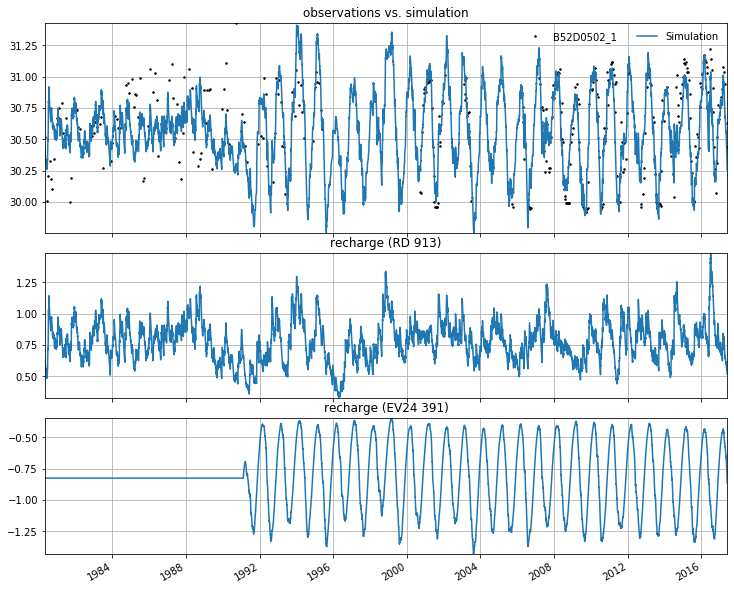

In [18]:
# add evaporation
fname = os.path.join(datapath,'etmgeg_391.txt')
series = ps.read_knmi(fname, variables='EV24')
pr_q.add_series(series, kind='evap', settings='evap')

# add precipitation
fname = os.path.join(datapath,'neerslaggeg_IJSSELSTEYN-L_913.txt')
series = ps.read_knmi(fname, variables='RD')
pr_q.add_series(series, kind='prec', settings='prec')

# delete existing stresses
pr_q.del_stress('EV24 DE BILT')
pr_q.del_stress('RD 89')

# create and solve the models
for name in pr_q.oseries.index:
    ml = pr_q.add_model(name)
    pr_q.add_recharge(ml)
    ml.solve(report=False)
    
# get the statistics
print(pr_q.get_statistics(['evp']))

# results of individual model
name = 'B52D0502_1'
ml = pr_q.models[name]
ml.plots.decomposition();

#### <a href="#ex6">Answer exercise 6</a> <a name="ans6"></a>

B52C2089_1    59.358382
B52D0192_1    56.324289
B52D0192_2    79.749233
B52D0201_1    73.762643
B52D0201_2    84.374921
B52D0495_1    41.329586
B52D0495_2    39.014037
B52D0502_1    79.779845
Name: evp, dtype: float64


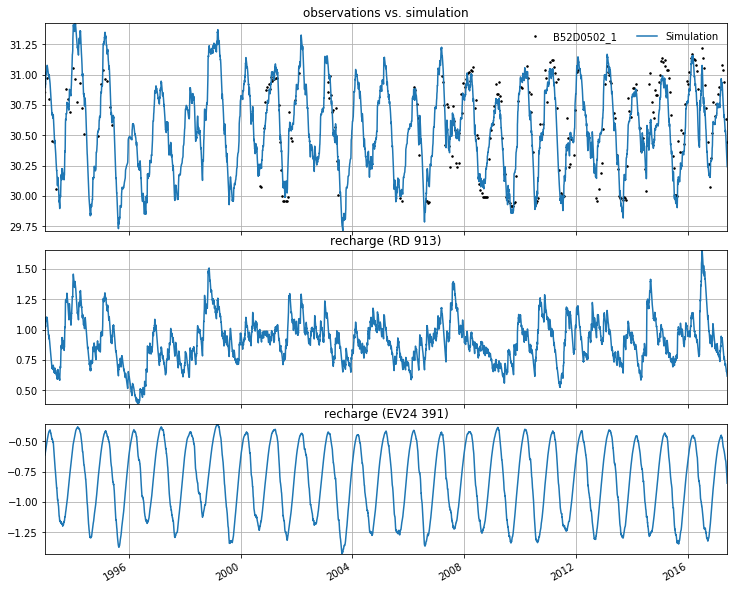

In [19]:
for name in pr_q.oseries.index:
    ml = pr_q.add_model(name)
    pr_q.add_recharge(ml)
    ml.solve(tmin='1993', report=False)
    
print(pr_q.get_statistics(['evp']))

# results of individual model
name = 'B52D0502_1'
ml = pr_q.models[name]
ml.plots.decomposition();

#### <a href="#ex7">Answer exercise 7</a> <a name="ans7"></a>

There seems to be little effect of the steptrend on the model results

B52C2089_1    63.069121
B52D0192_1    56.327095
B52D0192_2    80.003164
B52D0201_1    74.145835
B52D0201_2    84.375162
B52D0495_1    41.321653
B52D0495_2    38.783903
B52D0502_1    82.676331
Name: evp, dtype: float64


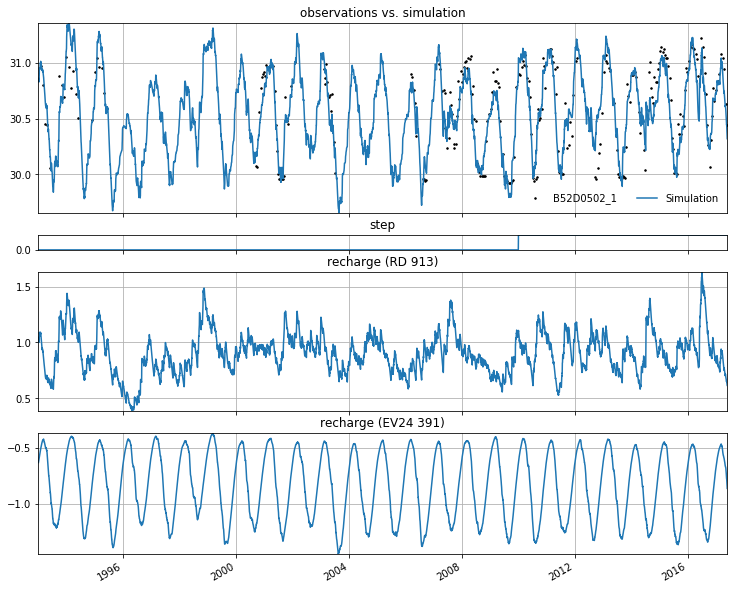

In [20]:
sm = ps.stressmodels.StepModel('2010', name='step', up=True)
sm2 = ps.stressmodels.StepModel('2013', name='step2', up=True)

for name in pr_q.oseries.index:
    ml = pr_q.add_model(name)
    ml.add_stressmodel(sm)
    #ml.add_stressmodel(sm2)
    pr_q.add_recharge(ml)
    ml.solve(tmin='1993', report=False)
    
print(pr_q.get_statistics(['evp']))

# results of individual model
name = 'B52D0502_1'
ml = pr_q.models[name]
ml.plots.decomposition();